In [4]:
import os
import sys
import math
import timeit

import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from datasets.NYUMultiDataset import NYUMultiDataset
from model.DepthGenLM import DepthGenLM

In [5]:
def plot_hands(ax, points, color, linewidth='3'):
    # Add bone connections
    bones = [(0, 1),
             (1, 2),
             (2, 3),
             (3, 4),
             (0, 21),
             (21, 5),
             (5, 6),
             (6, 7),
             (7, 8),
             (21, 9),
             (9, 10),
             (10, 11),
             (11, 12),
             (21, 13),
             (13, 14),
             (14, 15),
             (15, 16),
             (21, 17),
             (17, 18),
             (18, 19),
             (19, 20)]

    for connection in bones:
        coord1 = points[connection[0]]
        coord2 = points[connection[1]]
        coords = np.stack([coord1, coord2])
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], c=color, linewidth=linewidth)

In [24]:
tsfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224, Image.NEAREST),
    transforms.ToTensor(),
])

data_path = "/home/alex/Data/nyu/dataset/test/"
dataset = NYUMultiDataset(data_path, tsfms, tsfms, 1024, True, False)

In [7]:
mesh_path = "/home/alex/dev/projects/libhand-public/nyu_synth/ogre/hand.mesh.xml"
skeleton_path = "/home/alex/dev/projects/libhand-public/nyu_synth/ogre/hand.skeleton.xml"
checkpoint_path = "/home/alex/dev/projects/pytorch-depthgen/saved/resnet_multiview_synth_pretrain.ckpt"

model = DepthGenLM.load_from_checkpoint(checkpoint_path)

model.cuda()
model.eval()

DepthGenLM(
  (estimator): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Mean length = 0.5596885373195012


<IPython.core.display.Javascript object>


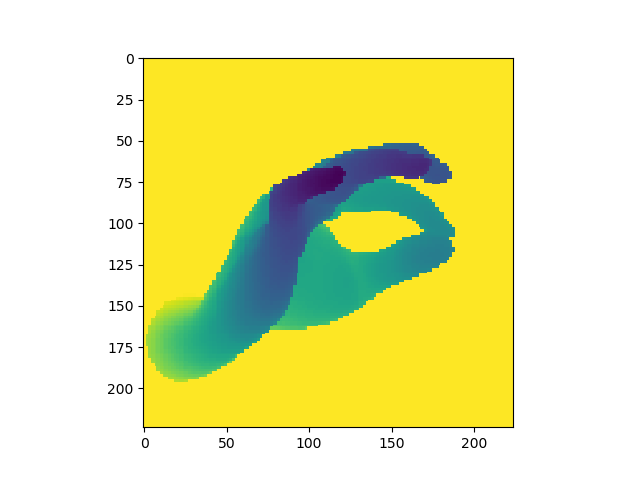

<IPython.core.display.Javascript object>


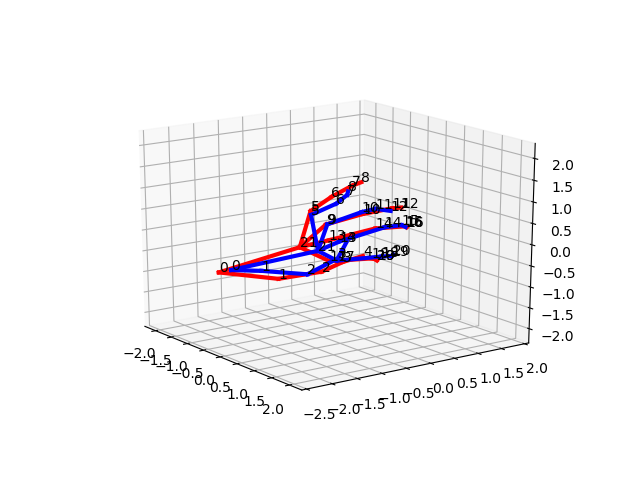

<IPython.core.display.Javascript object>


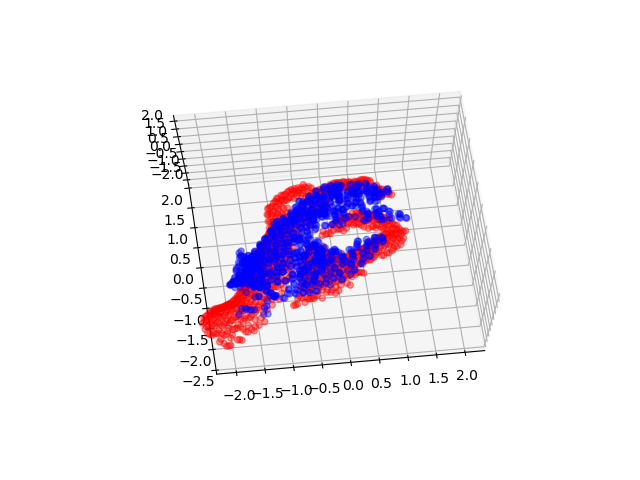

(-2.25, 2.25)

In [26]:
idx = torch.randint(0, len(dataset), [1]).item()
sample1, sample2 = dataset[idx]
sample, target, kps, kps14, center, norm_size, bbox, padding = sample1

joint_idxs = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 6]

# Default output
# x = torch.zeros(1, 17, 4, device=torch.device('cuda'))
# x[:, :, 0] = 1
# preds = model.depth_gen(x)

preds, _ = model(sample.unsqueeze(0).cuda())

points = preds[0]
coords = preds[2]
points_vis = points[0].detach().cpu()
coords_vis = coords[0, joint_idxs].detach().cpu()

kp_vis = kps.cpu()

# Normalization length
segments = np.array([
    [1, 2],
    [2, 3],
    [3, 4],
    [5, 6],
    [6, 7],
    [7, 8],
    [9, 10],
    [10, 11],
    [11, 12],
    [13, 14],
    [14, 15],
    [15, 16],
    [17, 18],
    [18, 19],
    [19, 20]
])

total_length = 0
for idx, val in enumerate(segments):
    l = np.linalg.norm(kp_vis[val[0]] - kp_vis[val[1]])
    total_length += l
    
mean_length = total_length / segments.shape[0]
print("Mean length = {}".format(mean_length))

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(sample[0])

kp_fig = plt.figure()
kp_ax = kp_fig.add_subplot(111, projection='3d')
kp_ax.view_init(90, -90)
kp_ax.set_xlim([-2.25, 2.25])
kp_ax.set_ylim([-2.5, 2.0])
kp_ax.set_zlim([-2.25, 2.25])
plot_hands(kp_ax, kp_vis, color='r')
plot_hands(kp_ax, coords_vis, color='b')
annotations = [str(i) for i in range(22)]
for i, anno in enumerate(annotations):
    kp_ax.text(kps[i, 0], kps[i, 1], kps[i, 2], anno)
    kp_ax.text(coords_vis[i, 0], coords_vis[i, 1], coords_vis[i, 2], anno)

pc_fig = plt.figure()
pc_ax = pc_fig.add_subplot(111, projection='3d')
pc_ax.view_init(90, -90)
pc_ax.scatter(target[:, 0], target[:, 1], target[:, 2], alpha=0.4, c='r')
pc_ax.scatter(points_vis[:, 0], points_vis[:, 1], points_vis[:, 2], alpha=0.4, c='b')
pc_ax.set_xlim([-2.25, 2.25])
pc_ax.set_ylim([-2.5, 2.0])
pc_ax.set_zlim([-2.25, 2.25])